In [1]:
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import radical.utils as ru
import radical.pilot as rp
import radical.analytics as ra

from IPython.core.display import display, HTML

pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_rows', 50)

/Users/mturilli/Virtualenvs/RP-PAPER-IPDPS18/lib/python2.7/site-packages/radical/utils/atfork/stdlib_fixer.py:63: UserWarning: logging module already imported before fixup.
  warnings.warn('logging module already imported before fixup.')


In [2]:
# Global configurations
# ---------------------

# Expand the notebook to the width of the browser
display(HTML("<style>.container { width:100% !important; }</style>"))

# Matplotlib style
plt.style.use('seaborn-ticks')

# Use LaTeX and its body font for the diagrams' text.
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif']  = ['Nimbus Roman Becker No9L']

# Font sizes
SIZE = 24
plt.rc('font', size=SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)  # fontsize of the x any y labels
plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE-2)  # legend fontsize
plt.rc('figure', titlesize=SIZE)  # # size of the figure title

# Use thinner lines for axes to avoid distractions.
mpl.rcParams['axes.linewidth']    = 0.75
mpl.rcParams['xtick.major.width'] = 0.75
mpl.rcParams['xtick.minor.width'] = 0.75
mpl.rcParams['ytick.major.width'] = 0.75
mpl.rcParams['ytick.minor.width'] = 0.75
mpl.rcParams['lines.linewidth'] = 2


# Do not use a box for the legend to avoid distractions.
mpl.rcParams['legend.frameon'] = False

# Restore part of matplotlib 1.5 behavior
mpl.rcParams['patch.force_edgecolor'] = True
mpl.rcParams['errorbar.capsize'] = 3

# Helpers
# -------

# Use coordinated colors. These are the "Tableau 20" colors as 
# RGB. Each pair is strong/light. For a theory of color    
tableau20 = [(31 , 119, 180), (174, 199, 232), # blue        [ 0,1 ]
             (255, 127, 14 ), (255, 187, 120), # orange      [ 2,3 ]
             (44 , 160, 44 ), (152, 223, 138), # green       [ 4,5 ]
             (214, 39 , 40 ), (255, 152, 150), # red         [ 6,7 ]
             (148, 103, 189), (197, 176, 213), # purple      [ 8,9 ]
             (140, 86 , 75 ), (196, 156, 148), # brown       [10,11]
             (227, 119, 194), (247, 182, 210), # pink        [12,13]
             (188, 189, 34 ), (219, 219, 141), # yellow      [14,15]
             (23 , 190, 207), (158, 218, 229), # cyan        [16,17]
             (65 , 68 , 81 ), (96 , 99 , 106), # gray        [18,19]
             (127, 127, 127), (143, 135, 130), # gray        [20,21] 
             (165, 172, 175), (199, 199, 199), # gray        [22,23]
             (207, 207, 207)]                   # gray        [24]
  
# Scale the RGB values to the [0, 1] range, which is the format 
# matplotlib accepts.    
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)    

# Return a single plot without right and top axes
def fig_setup():
    fig = plt.figure(figsize=(13,7))
    ax = fig.add_subplot(111)  
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)  
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()
    
    return fig, ax

In [3]:
# Load wrangled data saved in .csv files for both synapse and gromacs.
synapse_sessions = pd.read_csv('data/synapse/sessions.csv', index_col=0)
synapse_pilots = pd.read_csv('data/synapse/pilots.csv', index_col=0)
synapse_units = pd.read_csv('data/synapse/units.csv', index_col=0)

gromacs_sessions = pd.read_csv('data/sessions.csv', index_col=0)
gromacs_pilots = pd.read_csv('data/pilots.csv', index_col=0)
gromacs_units = pd.read_csv('data/units.csv', index_col=0)

In [4]:
print 'Synapse: Total number of successful runs: %s' % synapse_sessions.shape[0]
print 'Synapse: Total number of pilots: %s' % synapse_pilots.shape[0]
print 'Synapse: Total number of units: %s\n' % synapse_units.shape[0]

print 'GROMACS: Total number of successful runs: %s' % gromacs_sessions.shape[0]
print 'GROMACS: Total number of pilots: %s' % gromacs_pilots.shape[0]
print 'GROMACS: Total number of units: %s' % gromacs_units.shape[0]

Synapse: Total number of successful runs: 9
Synapse: Total number of pilots: 9
Synapse: Total number of units: 5792

GROMACS: Total number of successful runs: 1
GROMACS: Total number of pilots: 1
GROMACS: Total number of units: 16384


# Synapse

## Weak Scaling (exp1)

Definitions: 
* Weak scalability: how the solution time varies with the number of processors for a fixed problem size per processor
* Ideal Runtime: the time taken by the workload to run on the given resources without any overhead
* Walltime: the walltime asked for the pilot
* Max Walltime: the maximum walltime that can be asked for the given size of the pilot

|N runs| N tasks | N core/task | N generations | N pilot | N core/pilot | Ideal Runtime  | Walltime | Max Walltime | Resource |
|------|---------|-------------|---------------|---------|--------------|----------------|----------|--------------|----------|
| 2    | 32      | 32          | 1             | 1       | 1024         | 15m            | 1h       | 1h           | Titan    |
| 2    | 64      | 32          | 1             | 1       | 2048         | 15m            | 1h       | 6h           | Titan    |
| 2    | 128     | 32          | 1             | 1       | 4096         | 15m            | 1h       | 6h           | Titan    |
| 2    | 256     | 32          | 1             | 1       | 8192         | 15m            | 1h       | 12h          | Titan    |
| 2    | 512     | 32          | 1             | 1       | 16384        | 15m            | 1h       | 12h          | Titan    |
| 2    | 1024    | 32          | 1             | 1       | 32768        | 15m            | 1h       | 12h          | Titan    |
| 2    | 2048    | 32          | 1             | 1       | 65536        | 15m            | 1h       | 24h          | Titan    |
| 2    | 4096    | 32          | 1             | 1       | 131072       | 15m            | 1h       | 24h          | Titan    |
| 2    | 8192    | 32          | 1             | 1       | 262144       | 15m            | 1h       | 24h          | Titan    |

In [5]:
synapse_wscaling = synapse_sessions[synapse_sessions.experiment == 'exp1'][
    ['nunit','TTC','P_LRMS_QUEUING','U_AGENT_QUEUING','U_AGENT_SCHEDULING','U_AGENT_QUEUING_EXEC','U_AGENT_EXECUTING']
        ].groupby(['nunit']).aggregate(
                {'TTC'                 : ['mean','std'],
                 'P_LRMS_QUEUING'      : ['mean','std'],
                 'U_AGENT_QUEUING'     : ['mean','std'],
                 'U_AGENT_SCHEDULING'  : ['mean','std'],
                 'U_AGENT_QUEUING_EXEC': ['mean','std'],
                 'U_AGENT_EXECUTING'   : ['mean','std']})

synapse_wscaling.rename_axis({'P_LRMS_QUEUING'      :'TTQ'}, axis='columns', inplace=True)
synapse_wscaling.rename_axis({'U_AGENT_QUEUING'     :'Agent queueing'}, axis='columns', inplace=True)
synapse_wscaling.rename_axis({'U_AGENT_SCHEDULING'  :'Agent scheduling'}, axis='columns', inplace=True)
synapse_wscaling.rename_axis({'U_AGENT_QUEUING_EXEC':'Agent queueing execution'}, axis='columns', inplace=True)
synapse_wscaling.rename_axis({'U_AGENT_EXECUTING'   :'TTX'}, axis='columns', inplace=True)
synapse_wscaling.rename(index={i: '%s/%s' % (i, i*32) for i in synapse_wscaling.index.get_values()}, inplace=True)
synapse_wscaling

TTQ               Agent queueing            Agent queueing execution                     TTX                      TTC               Agent scheduling           
                   mean           std           mean        std                     mean         std        mean         std         mean           std             mean        std
nunit                                                                                                                                                                              
32/1024       173.75460           NaN        0.31120        NaN                 0.488000         NaN   900.17170         NaN   1335.79830           NaN         0.276901        NaN
64/2048      2168.98005    767.091852        0.78775   0.041790                 1.085350    0.052396   922.82195   10.475858   3263.28320    657.528696         0.701950   0.036699
128/4096     1420.91340    486.405461        1.95545   0.014637                 2.754850    0.360978   932.86250    3.527897   2458.95405    481.298665         1.780050   0.004737
256/8192    10853.73040           NaN        5.43700        NaN                 5.327699         NaN   930.68280         NaN  12054.38070           NaN         5.019804        NaN
1024/32768  22572.75870           NaN       61.16850        NaN               128.907199         NaN  1091.80200         NaN  23770.91380           NaN        57.158904        NaN
2048/65536  19077.83980  20076.305415      226.35675  19.090115              1319.356600  384.335023  2284.67475  325.280786  21548.49390  19867.134461       217.454751  10.965037

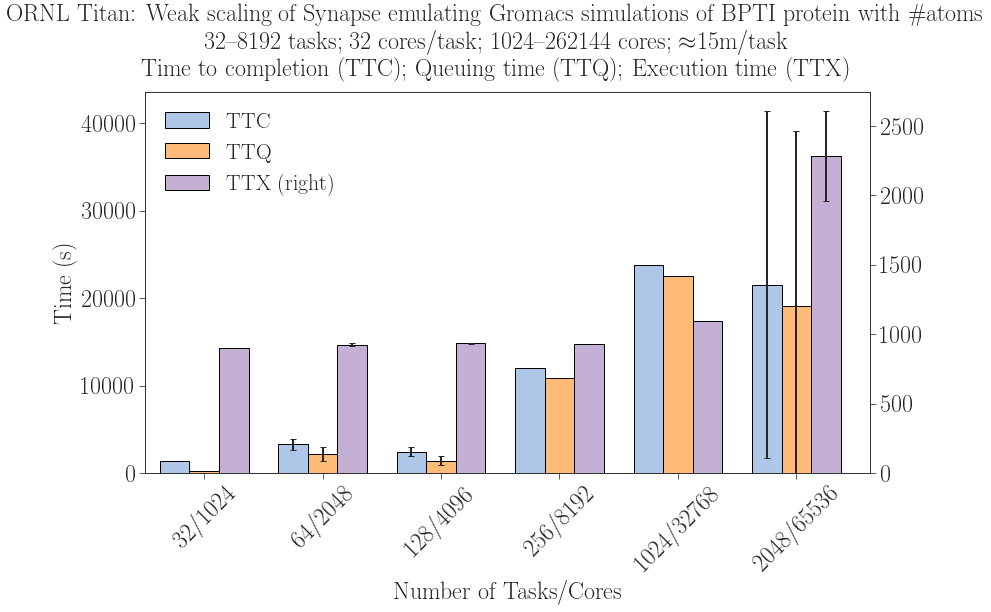

In [6]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111)  

title_head = 'ORNL Titan: Weak scaling of Synapse emulating Gromacs simulations of BPTI protein with \#atoms'
title_work = '32--8192 tasks; 32 cores/task; 1024--262144 cores; $\\approx$15m/task' 
title_desc = 'Time to completion (TTC); Queuing time (TTQ); Execution time (TTX)'
title = '%s\n%s\n%s' % (title_head, title_work, title_desc)
fig.suptitle(title, y=1.05)

# Plot means and std bars
synapse_wscaling['TTC'].reset_index().plot.bar(
    x='nunit', y='mean', yerr='std',
    position=1.5, width=0.25, color=tableau20[1], ax=ax, rot=45,
    label='TTC')

synapse_wscaling['TTQ'].reset_index().plot.bar(
    x='nunit', y='mean', yerr='std',
    position=0.5, width=0.25, color=tableau20[3], ax=ax, rot=45,
    label='TTQ')

synapse_wscaling['TTX'].reset_index().plot.bar(
    x='nunit', y='mean', yerr='std', 
    position=-0.5, width=0.25, color=tableau20[9], ax=ax, rot=45, secondary_y=True,
    label='TTX')

ax.set_xlabel('Number of Tasks/Cores')
ax.set_ylabel('Time (s)')
ax.set_ylim(0)
ax.set_xlim(-0.5)

plt.savefig('figures/titan_rp_weak_scaling.pdf', dpi=600, bbox_inches='tight')

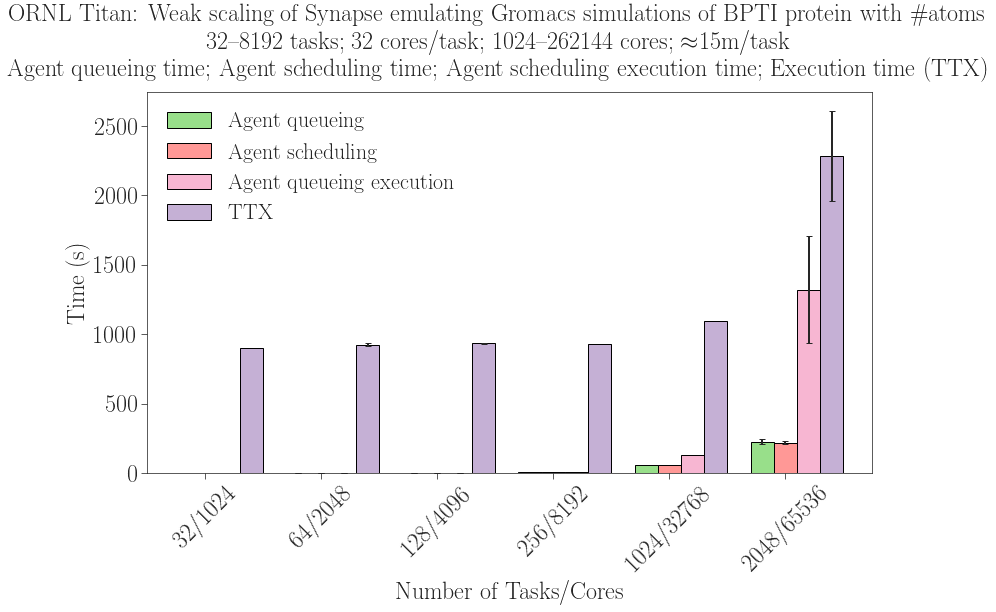

In [7]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111)  

title_head = 'ORNL Titan: Weak scaling of Synapse emulating Gromacs simulations of BPTI protein with \#atoms'
title_work = '32--8192 tasks; 32 cores/task; 1024--262144 cores; $\\approx$15m/task' 
title_desc = 'Agent queueing time; Agent scheduling time; Agent scheduling execution time; Execution time (TTX)'
title = '%s\n%s\n%s' % (title_head, title_work, title_desc)
fig.suptitle(title, y=1.05)

# Plot means and std bars
synapse_wscaling['Agent queueing'].reset_index().plot.bar(
    x='nunit', y='mean', yerr='std',
    position=1.5, width=0.20, color=tableau20[5], ax=ax, rot=45,
    label='Agent queueing')

synapse_wscaling['Agent scheduling'].reset_index().plot.bar(
    x='nunit', y='mean', yerr='std',
    position=0.5, width=0.20, color=tableau20[7], ax=ax, rot=45,
    label='Agent scheduling')

synapse_wscaling['Agent queueing execution'].reset_index().plot.bar(
    x='nunit', y='mean', yerr='std',
    position=-0.5, width=0.20, color=tableau20[13], ax=ax, rot=45,
    label='Agent queueing execution')

synapse_wscaling['TTX'].reset_index().plot.bar(
    x='nunit', y='mean', yerr='std', 
    position=-1.5, width=0.20, color=tableau20[9], ax=ax, rot=45,
    label='TTX')

ax.set_xlabel('Number of Tasks/Cores')
ax.set_ylabel('Time (s)')
ax.set_ylim(0)
ax.set_xlim(-0.5)

plt.savefig('figures/titan_agent_weak_scaling.pdf', dpi=600, bbox_inches='tight')

In [8]:
# List of events of RP
event_list = [
    # {ru.STATE: 'NEW'                          , ru.EVENT: 'state'           },
    # {ru.STATE: 'UMGR_SCHEDULING_PENDING'      , ru.EVENT: 'state'           },
    # {ru.STATE: 'UMGR_SCHEDULING'              , ru.EVENT: 'state'           },
    # {ru.STATE: 'UMGR_STAGING_INPUT_PENDING'   , ru.EVENT: 'state'           },
    # {ru.STATE: 'UMGR_STAGING_INPUT'           , ru.EVENT: 'state'           },
    # {ru.STATE: 'AGENT_STAGING_INPUT_PENDING'  , ru.EVENT: 'state'           },
    # {ru.COMP : 'agent_0'                      , ru.EVENT: 'get'             },
    # {ru.STATE: 'AGENT_STAGING_INPUT'          , ru.EVENT: 'state'           },
    # {ru.STATE: 'AGENT_SCHEDULING_PENDING'     , ru.EVENT: 'state'           },
    # {ru.STATE: 'AGENT_SCHEDULING'             , ru.EVENT: 'state'           },
      {ru.STATE: None                           , ru.EVENT: 'schedule_ok'     },
    # {ru.STATE: 'AGENT_EXECUTING_PENDING'      , ru.EVENT: 'state'           },
      {ru.STATE: 'AGENT_EXECUTING'              , ru.EVENT: 'state'           },
      {ru.STATE: None                           , ru.EVENT: 'exec_start'      },
    # {ru.STATE: None                           , ru.EVENT: 'exec_ok'         },
      {ru.STATE: None                           , ru.EVENT: 'exec_stop'       },
    # {ru.STATE: None                           , ru.EVENT: 'unschedule_start'},
      {ru.STATE: None                           , ru.EVENT: 'unschedule_stop' },
    # {ru.STATE: 'AGENT_STAGING_OUTPUT_PENDING' , ru.EVENT: 'state'           },
    # {ru.STATE: 'UMGR_STAGING_OUTPUT_PENDING'  , ru.EVENT: 'state'           },
    # {ru.STATE: 'UMGR_STAGING_OUTPUT'          , ru.EVENT: 'state'           },
    # {ru.STATE: 'AGENT_STAGING_OUTPUT'         , ru.EVENT: 'state'           },
    # {ru.STATE: 'DONE'                         , ru.EVENT: 'state'           },
]

In [9]:
# load ra session objects.
path = '/Users/mturilli/Projects/RADICAL/github/experiments/rp-paper-ipdps2018/analysis/data/synapse'

# number of units in the sessions
snunits = sorted(synapse_sessions.nunit.unique().tolist())

# load the RA session objects 
sras = {}
for snunit in snunits:
    sras[snunit] = []
    s = synapse_sessions[(synapse_sessions.nunit == snunit)]
    for sid in s.sid.tolist():
        exp = s.loc[sid]['experiment']
        src = '%s/%s/%s' % (path, exp, sid)
        sras[snunit].append(ra.Session(src, 'radical.pilot'))

In [10]:
# Collect timestamps of all the event specified in event_list for every unit
def getdf_unit_events(session):
    s = session # sras[2048][0]
    s.filter(etype='unit', inplace=True)
    data = dict()
    for thing in s.get():

        tstamps = dict()
        for event in event_list:
            eid = event[1]
            if eid == 'state': eid = event[5]            
            times = thing.timestamps(event=event)
            if times: tstamps[eid] = times[0]
            else    : tstamps[eid] = None

        data[thing.uid] = tstamps

    # We sort the entities by the timestamp of the first event
    # Also, for all timestamps, we move the baseline to the first
    # timestamp in the list
    df = pd.DataFrame.from_dict(data)
    df = df.sort_values(by=list(df.columns))
    df = df.transpose()
    df = df.reset_index()
    # df = df.sort_values(by=list(df.columns))

    # Rename events to make them intellegible
    df.rename_axis(
        {'index'           :'uid',
         'schedule_ok'     :'Scheduled',
         'AGENT_EXECUTING' :'Spawned',
         'exec_start'      :'Start Execution',
         'exec_stop'       :'Stop Execution',
         'unschedule_stop' :'Unscheduled'}, 
        axis='columns', inplace=True)
    
    # Durations
    df['Scheduling'] = df['Spawned'] - df['Scheduled']
    df['Spawning'] = df['Start Execution'] - df['Spawned']
    df['Executing'] = df['Stop Execution'] - df['Start Execution']
    df['Unscheduling'] = df['Unscheduled'] - df['Stop Execution']
    
    return df

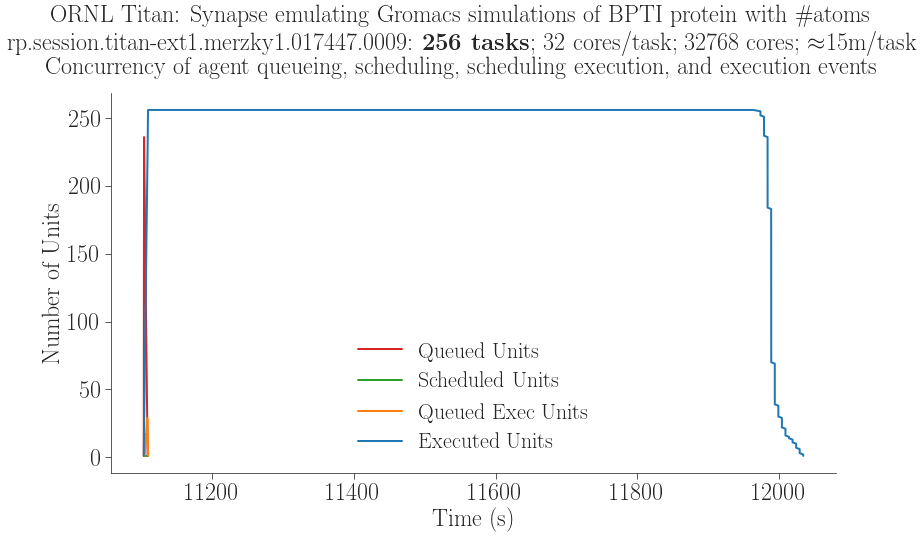

In [11]:
fig, ax = fig_setup()

title_head = 'ORNL Titan: Synapse emulating Gromacs simulations of BPTI protein with \#atoms'
title_work = '%s: \\textbf{256 tasks}; 32 cores/task; 32768 cores; $\\approx$15m/task' % sras[256][0]._sid
title_desc = 'Concurrency of agent queueing, scheduling, scheduling execution, and execution events'
title = '%s\n%s\n%s' % (title_head, title_work, title_desc)
fig.suptitle(title, y=1.05)

# Plot concurrent active units
scu = sras[256][0].concurrency(state=['AGENT_SCHEDULING_PENDING', 'AGENT_SCHEDULING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[6])

# Plot concurrent scheduled units
scu = sras[256][0].concurrency(state=['AGENT_SCHEDULING', 'AGENT_EXECUTING_PENDING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[4])

# Plot concurrent queued units
scu = sras[256][0].concurrency(state=['AGENT_EXECUTING_PENDING', 'AGENT_EXECUTING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[2])

# Plot concurrent active units
scu = sras[256][0].concurrency(state=['AGENT_EXECUTING', 'AGENT_STAGING_OUTPUT_PENDING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[0])

plt.xlabel('Time (s)')
plt.ylabel('Number of Units')
ax.legend(labels=['Queued Units', 'Scheduled Units', 'Queued Exec Units', 'Executed Units'])

plt.savefig('figures/titan_agent_concurrency_256.pdf', dpi=600, bbox_inches='tight')

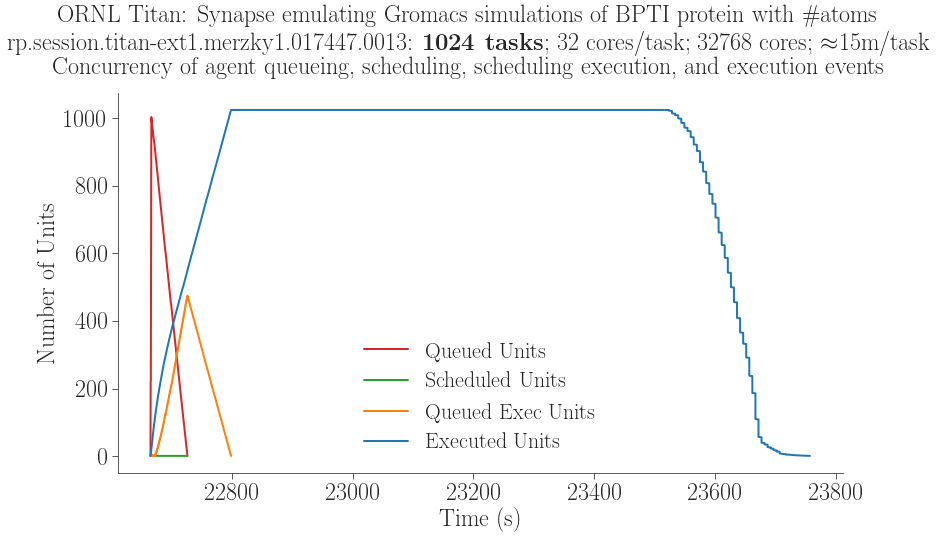

In [12]:
fig, ax = fig_setup()

title_head = 'ORNL Titan: Synapse emulating Gromacs simulations of BPTI protein with \#atoms'
title_work = '%s: \\textbf{1024 tasks}; 32 cores/task; 32768 cores; $\\approx$15m/task' % sras[1024][0]._sid
title_desc = 'Concurrency of agent queueing, scheduling, scheduling execution, and execution events'
title = '%s\n%s\n%s' % (title_head, title_work, title_desc)
fig.suptitle(title, y=1.05)

# Plot concurrent active units
scu = sras[1024][0].concurrency(state=['AGENT_SCHEDULING_PENDING', 'AGENT_SCHEDULING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[6])

# Plot concurrent scheduled units
scu = sras[1024][0].concurrency(state=['AGENT_SCHEDULING', 'AGENT_EXECUTING_PENDING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[4])

# Plot concurrent queued units
scu = sras[1024][0].concurrency(state=['AGENT_EXECUTING_PENDING', 'AGENT_EXECUTING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[2])

# Plot concurrent active units
scu = sras[1024][0].concurrency(state=['AGENT_EXECUTING', 'AGENT_STAGING_OUTPUT_PENDING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[0])

plt.xlabel('Time (s)')
plt.ylabel('Number of Units')
ax.legend(labels=['Queued Units', 'Scheduled Units', 'Queued Exec Units', 'Executed Units'])

plt.savefig('figures/titan_agent_concurrency_1024.pdf', dpi=600, bbox_inches='tight')

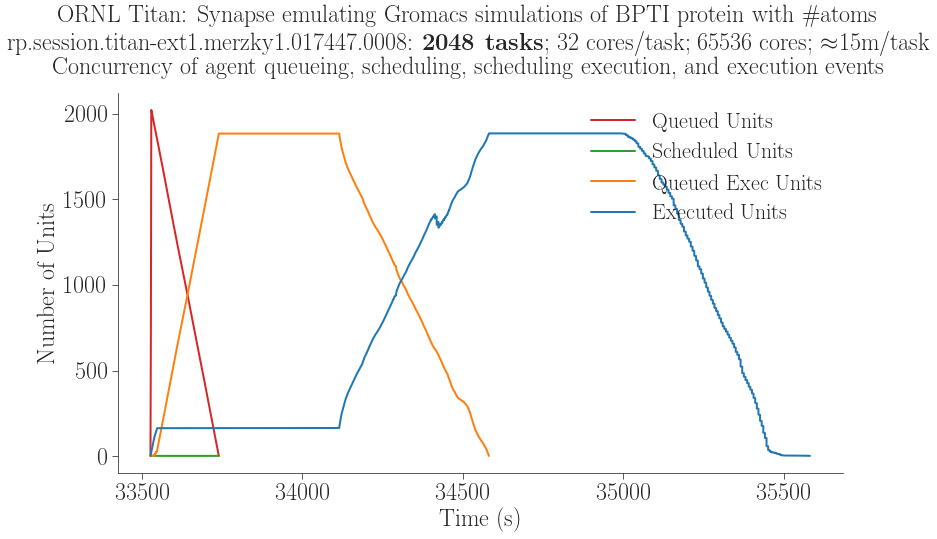

In [13]:
fig, ax = fig_setup()

title_head = 'ORNL Titan: Synapse emulating Gromacs simulations of BPTI protein with \#atoms'
title_work = '%s: \\textbf{2048 tasks}; 32 cores/task; 65536 cores; $\\approx$15m/task' % sras[2048][0]._sid
title_desc = 'Concurrency of agent queueing, scheduling, scheduling execution, and execution events'
title = '%s\n%s\n%s' % (title_head, title_work, title_desc)
fig.suptitle(title, y=1.05)

# Plot concurrent active units
scu = sras[2048][0].concurrency(state=['AGENT_SCHEDULING_PENDING', 'AGENT_SCHEDULING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[6])

# Plot concurrent scheduled units
scu = sras[2048][0].concurrency(state=['AGENT_SCHEDULING', 'AGENT_EXECUTING_PENDING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[4])

# Plot concurrent queued units
scu = sras[2048][0].concurrency(state=['AGENT_EXECUTING_PENDING', 'AGENT_EXECUTING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[2])

# Plot concurrent active units
scu = sras[2048][0].concurrency(state=['AGENT_EXECUTING', 'AGENT_STAGING_OUTPUT_PENDING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[0])

plt.xlabel('Time (s)')
plt.ylabel('Number of Units')
ax.legend(labels=['Queued Units', 'Scheduled Units', 'Queued Exec Units', 'Executed Units'])

plt.savefig('figures/titan_agent_concurrency_2048_a.pdf', dpi=600, bbox_inches='tight')

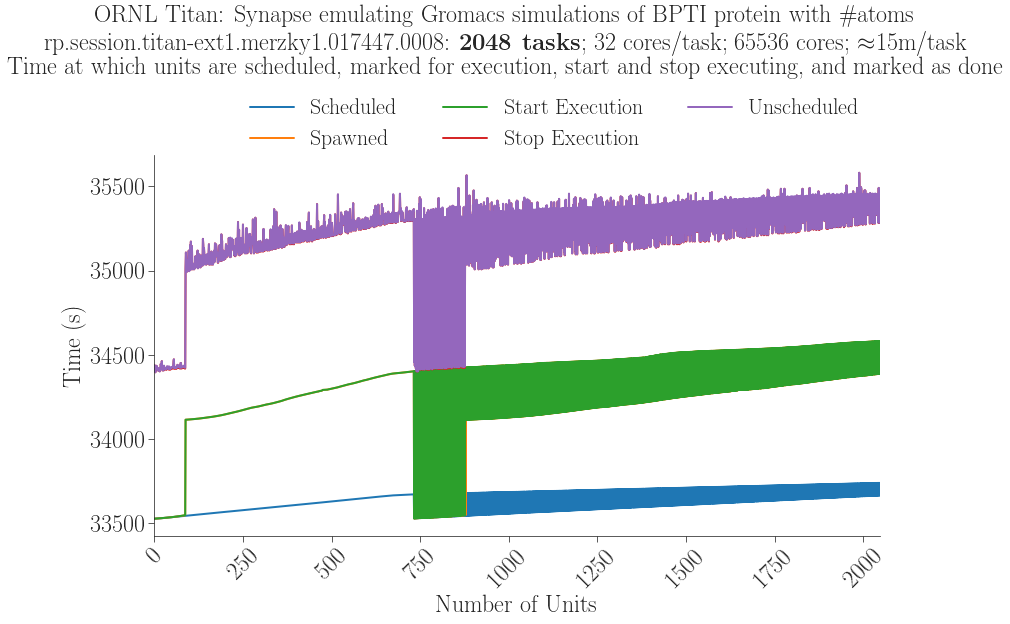

In [14]:
session = sras[2048][0]
fig, ax = fig_setup()

title_head = 'ORNL Titan: Synapse emulating Gromacs simulations of BPTI protein with \#atoms'
title_work = '%s: \\textbf{2048 tasks}; 32 cores/task; 65536 cores; $\\approx$15m/task' % session._sid
title_desc = 'Time at which units are scheduled, marked for execution, start and stop executing, and marked as done'
title = '%s\n%s\n%s' % (title_head, title_work, title_desc)
fig.suptitle(title, y=1.175)

df = getdf_unit_events(session)
# df = df.sort_values(by=list(df.columns))
timestamps = df[['Scheduled','Spawned', 'Start Execution', 'Stop Execution', 'Unscheduled']]

timestamps.plot(ax=ax, rot=45)

plt.legend(bbox_to_anchor=(1,1.2), ncol=3)
plt.xlabel('Number of Units')
plt.ylabel('Time (s)')

plt.savefig('figures/titan_unit_events_2048.pdf', dpi=600, bbox_inches='tight')

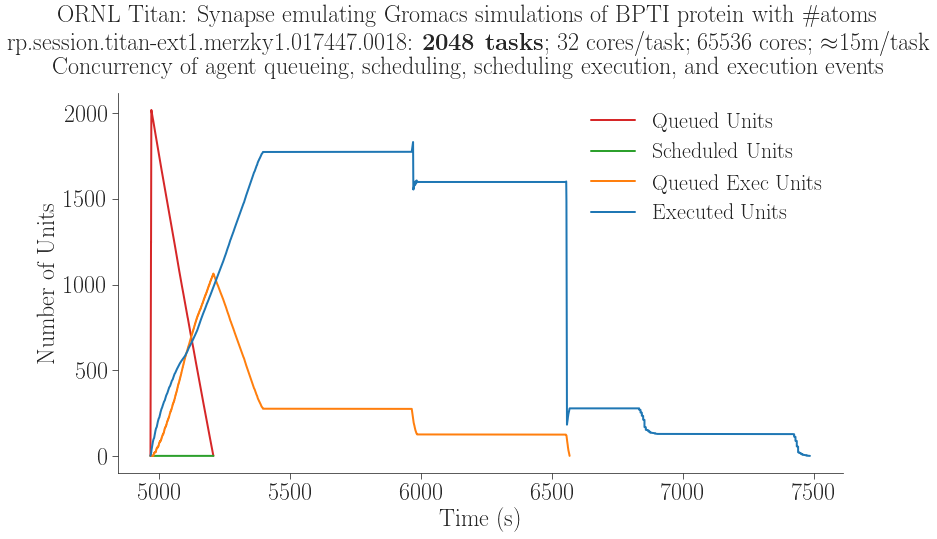

In [15]:
fig, ax = fig_setup()

title_head = 'ORNL Titan: Synapse emulating Gromacs simulations of BPTI protein with \#atoms'
title_work = '%s: \\textbf{2048 tasks}; 32 cores/task; 65536 cores; $\\approx$15m/task' % sras[2048][1]._sid
title_desc = 'Concurrency of agent queueing, scheduling, scheduling execution, and execution events'
title = '%s\n%s\n%s' % (title_head, title_work, title_desc)
fig.suptitle(title, y=1.05)

# Plot concurrent active units
scu = sras[2048][1].concurrency(state=['AGENT_SCHEDULING_PENDING', 'AGENT_SCHEDULING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[6])

# Plot concurrent scheduled units
scu = sras[2048][1].concurrency(state=['AGENT_SCHEDULING', 'AGENT_EXECUTING_PENDING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[4])

# Plot concurrent queued units
scu = sras[2048][1].concurrency(state=['AGENT_EXECUTING_PENDING', 'AGENT_EXECUTING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[2])

# Plot concurrent active units
scu = sras[2048][1].concurrency(state=['AGENT_EXECUTING', 'AGENT_STAGING_OUTPUT_PENDING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[0])

plt.xlabel('Time (s)')
plt.ylabel('Number of Units')
ax.legend(labels=['Queued Units', 'Scheduled Units', 'Queued Exec Units', 'Executed Units'])

plt.savefig('figures/titan_agent_concurrency_2048_b.pdf', dpi=600, bbox_inches='tight')

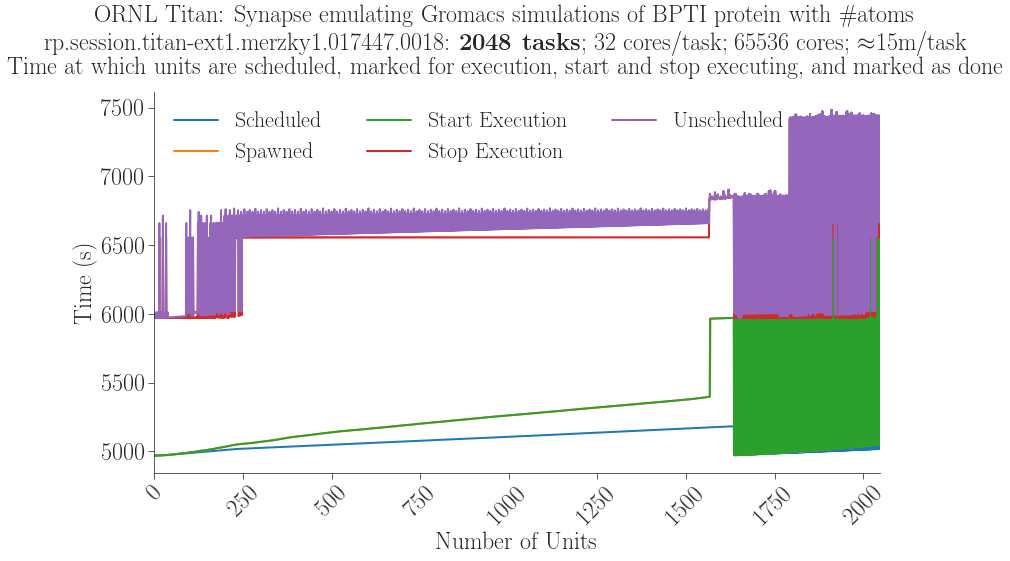

In [16]:
session = sras[2048][1]
fig, ax = fig_setup()

title_head = 'ORNL Titan: Synapse emulating Gromacs simulations of BPTI protein with \#atoms'
title_work = '%s: \\textbf{2048 tasks}; 32 cores/task; 65536 cores; $\\approx$15m/task' % session._sid
title_desc = 'Time at which units are scheduled, marked for execution, start and stop executing, and marked as done'
title = '%s\n%s\n%s' % (title_head, title_work, title_desc)
fig.suptitle(title, y=1.05)

df = getdf_unit_events(session)
# df = df.sort_values(by=list(df.columns))
df.reset_index(inplace=True)
timestamps = df[['Scheduled','Spawned', 'Start Execution', 'Stop Execution', 'Unscheduled']]

timestamps.plot(ax=ax, rot=45)

plt.legend(ncol=3)
plt.xlabel('Number of Units')
plt.ylabel('Time (s)')

plt.savefig('figures/titan_unit_events_2048_b.pdf', dpi=600, bbox_inches='tight')

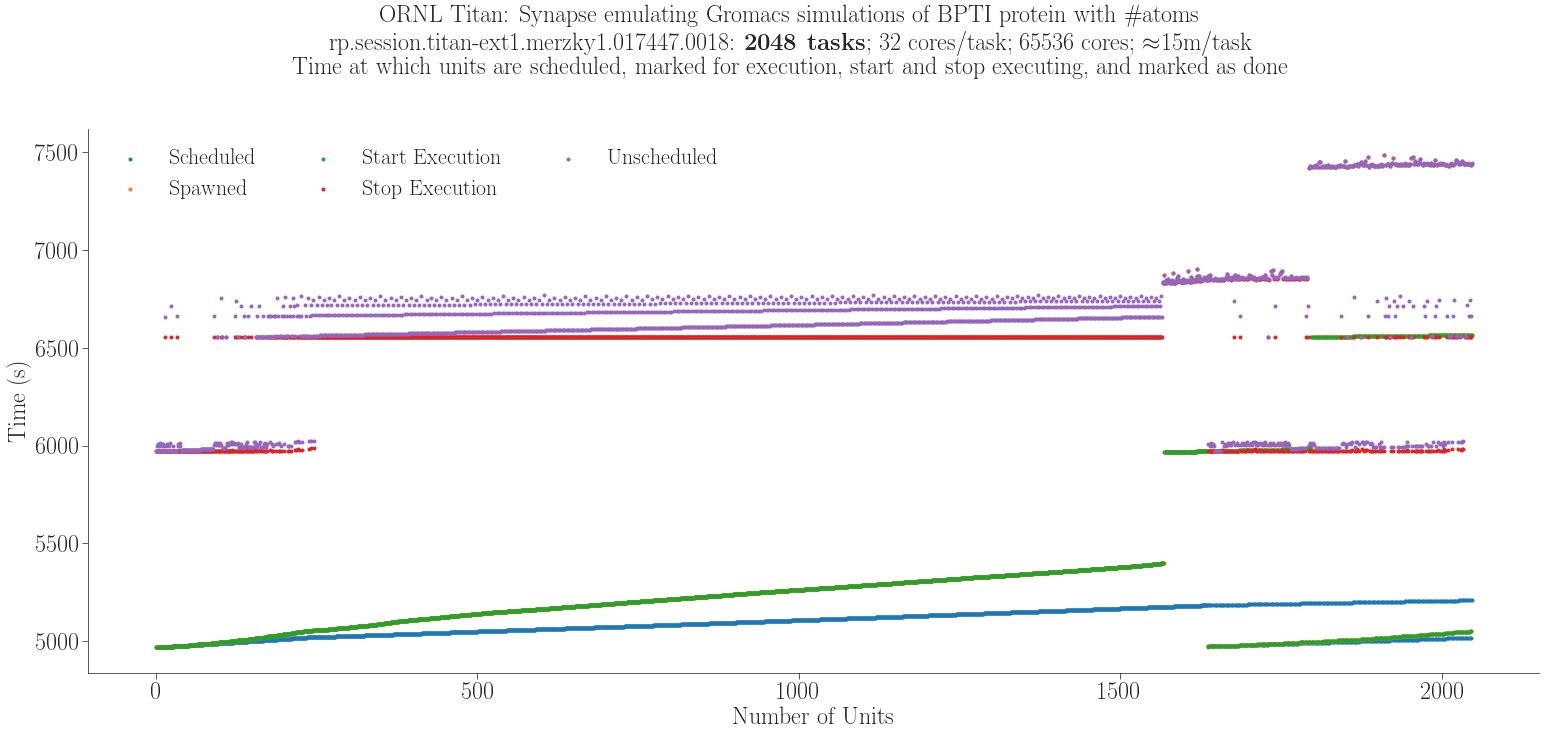

In [17]:
session = sras[2048][1]
fig = plt.figure(figsize=(26,10))
ax = fig.add_subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()

title_head = 'ORNL Titan: Synapse emulating Gromacs simulations of BPTI protein with \#atoms'
title_work = '%s: \\textbf{2048 tasks}; 32 cores/task; 65536 cores; $\\approx$15m/task' % session._sid
title_desc = 'Time at which units are scheduled, marked for execution, start and stop executing, and marked as done'
title = '%s\n%s\n%s' % (title_head, title_work, title_desc)
fig.suptitle(title, y=1.05)

df = getdf_unit_events(session)
df.reset_index(inplace=True)

plt.scatter(df.Scheduled.index, df.Scheduled, marker='.')
plt.scatter(df.Spawned.index, df.Spawned, marker='.')
plt.scatter(df['Start Execution'].index, df['Start Execution'], marker='.')
plt.scatter(df['Stop Execution'].index, df['Stop Execution'], marker='.')
plt.scatter(df.Unscheduled.index, df.Unscheduled, marker='.')

plt.legend(ncol=3)
plt.xlabel('Number of Units')
plt.ylabel('Time (s)')

# plt.savefig('figures/titan_unit_events_2048_b.pdf', dpi=600, bbox_inches='tight')

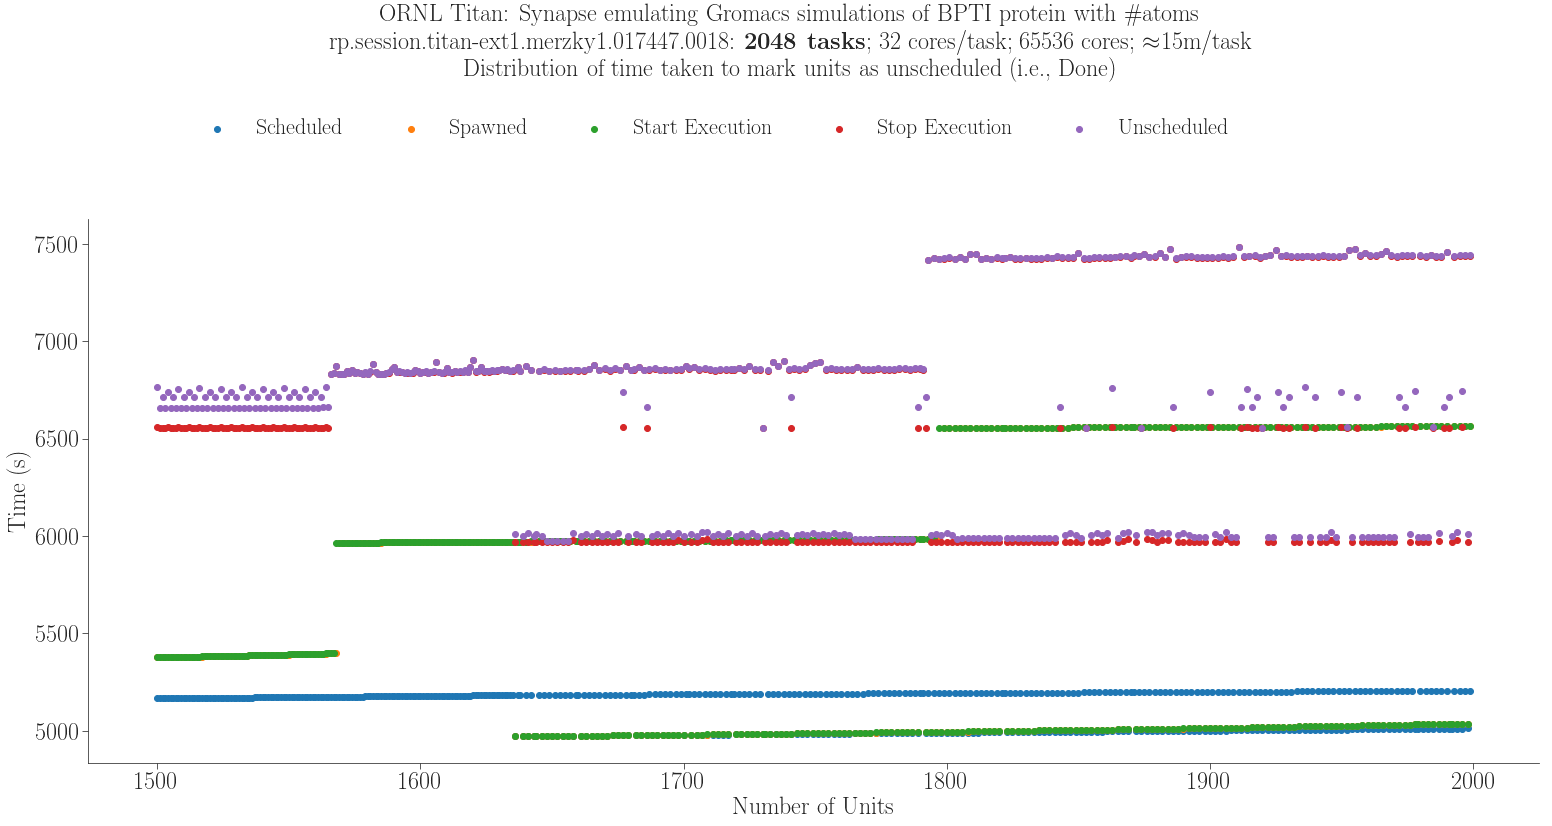

In [18]:
session = sras[2048][1]
fig = plt.figure(figsize=(26,10))
ax = fig.add_subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()

title_head = 'ORNL Titan: Synapse emulating Gromacs simulations of BPTI protein with \#atoms'
title_work = '%s: \\textbf{2048 tasks}; 32 cores/task; 65536 cores; $\\approx$15m/task' % session._sid
title_desc = 'Distribution of time taken to mark units as unscheduled (i.e., Done)'
title = '%s\n%s\n%s' % (title_head, title_work, title_desc)
fig.suptitle(title, y=1.175)

df = getdf_unit_events(session)
df = df.iloc[1500:2000]

plt.scatter(df.Scheduled.index, df.Scheduled)
plt.scatter(df.Spawned.index, df.Spawned)
plt.scatter(df['Start Execution'].index, df['Start Execution'])
plt.scatter(df['Stop Execution'].index, df['Stop Execution'])
plt.scatter(df.Unscheduled.index, df.Unscheduled)

plt.legend(bbox_to_anchor=(0.8,1.22), ncol=5)
plt.xlabel('Number of Units')
plt.ylabel('Time (s)')

# plt.savefig('figures/titan_unit_events_2048_b.pdf', dpi=600, bbox_inches='tight')

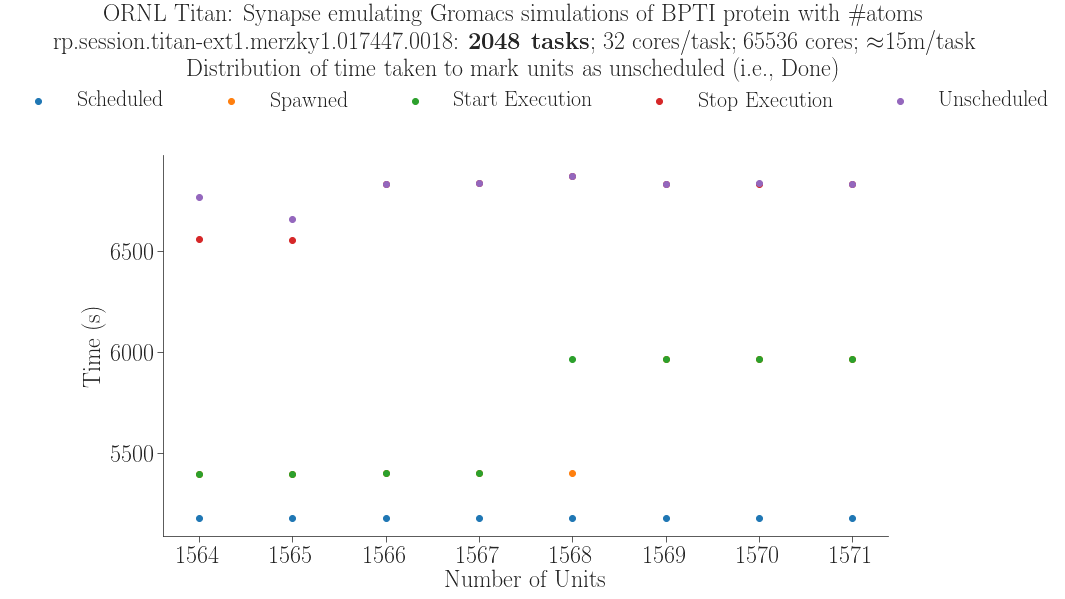

In [19]:
session = sras[2048][1]
fig, ax = fig_setup()

title_head = 'ORNL Titan: Synapse emulating Gromacs simulations of BPTI protein with \#atoms'
title_work = '%s: \\textbf{2048 tasks}; 32 cores/task; 65536 cores; $\\approx$15m/task' % session._sid
title_desc = 'Distribution of time taken to mark units as unscheduled (i.e., Done)'
title = '%s\n%s\n%s' % (title_head, title_work, title_desc)
fig.suptitle(title, y=1.175)

df = getdf_unit_events(session)
df = df.iloc[1564:1572]

plt.scatter(df.Scheduled.index, df.Scheduled)
plt.scatter(df.Spawned.index, df.Spawned)
plt.scatter(df['Start Execution'].index, df['Start Execution'])
plt.scatter(df['Stop Execution'].index, df['Stop Execution'])
plt.scatter(df.Unscheduled.index, df.Unscheduled)

plt.legend(bbox_to_anchor=(1.25,1.22), ncol=5)
plt.xlabel('Number of Units')
plt.ylabel('Time (s)')

# plt.savefig('figures/titan_unit_events_2048_b.pdf', dpi=600, bbox_inches='tight')

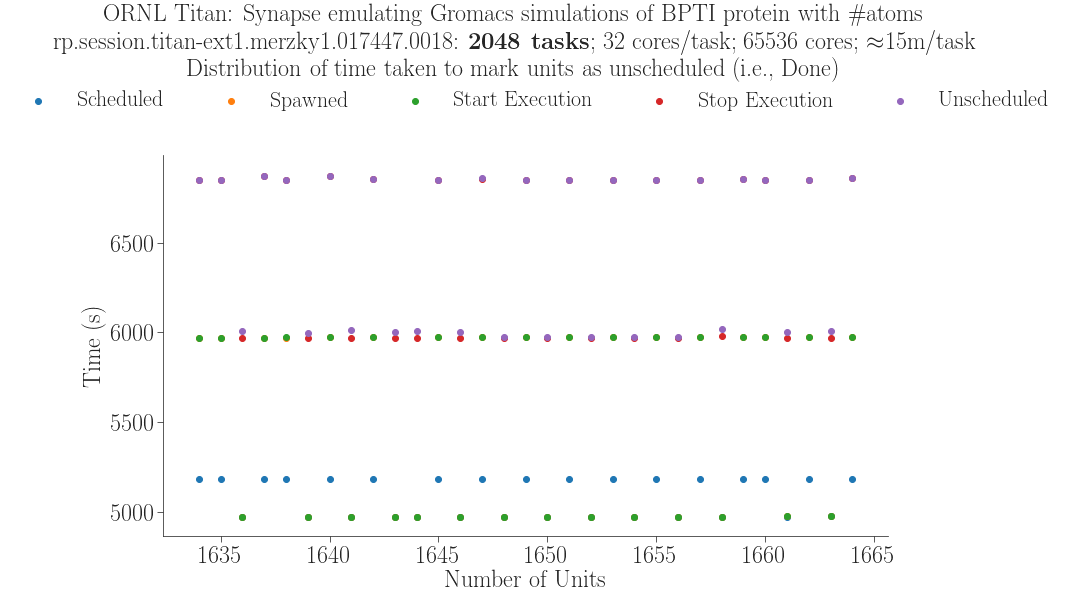

In [20]:
session = sras[2048][1]
fig, ax = fig_setup()

title_head = 'ORNL Titan: Synapse emulating Gromacs simulations of BPTI protein with \#atoms'
title_work = '%s: \\textbf{2048 tasks}; 32 cores/task; 65536 cores; $\\approx$15m/task' % session._sid
title_desc = 'Distribution of time taken to mark units as unscheduled (i.e., Done)'
title = '%s\n%s\n%s' % (title_head, title_work, title_desc)
fig.suptitle(title, y=1.175)

df = getdf_unit_events(session)
df = df.iloc[1634:1665]

plt.scatter(df.Scheduled.index, df.Scheduled)
plt.scatter(df.Spawned.index, df.Spawned)
plt.scatter(df['Start Execution'].index, df['Start Execution'])
plt.scatter(df['Stop Execution'].index, df['Stop Execution'])
plt.scatter(df.Unscheduled.index, df.Unscheduled)

plt.legend(bbox_to_anchor=(1.25,1.22), ncol=5)
plt.xlabel('Number of Units')
plt.ylabel('Time (s)')

# plt.savefig('figures/titan_unit_events_2048_b.pdf', dpi=600, bbox_inches='tight')

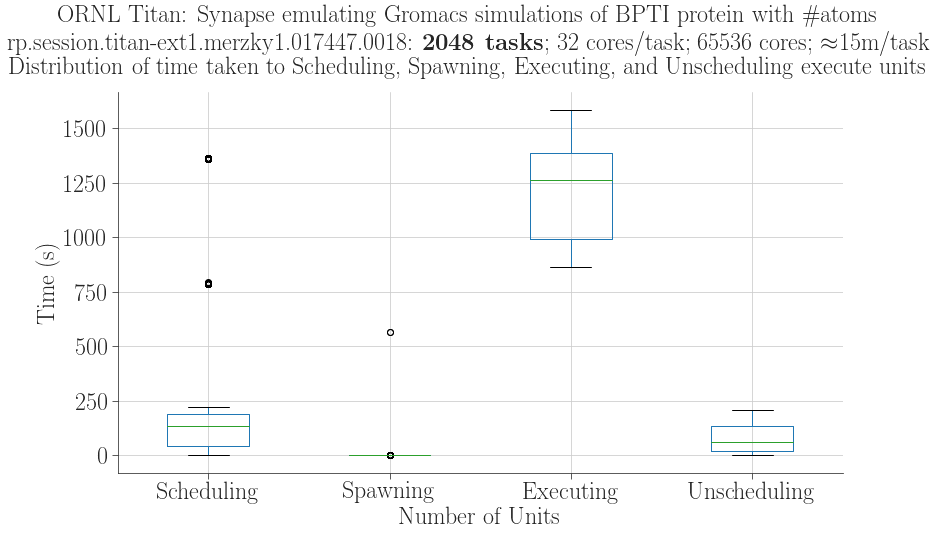

In [21]:
session = sras[2048][1]
fig, ax = fig_setup()

title_head = 'ORNL Titan: Synapse emulating Gromacs simulations of BPTI protein with \#atoms'
title_work = '%s: \\textbf{2048 tasks}; 32 cores/task; 65536 cores; $\\approx$15m/task' % session._sid
title_desc = 'Distribution of time taken to Scheduling, Spawning, Executing, and Unscheduling execute units'
title = '%s\n%s\n%s' % (title_head, title_work, title_desc)
fig.suptitle(title, y=1.05)

df = getdf_unit_events(session)

df[['Scheduling','Spawning', 'Executing', 'Unscheduling']].boxplot(ax=ax)

plt.xlabel('Number of Units')
plt.ylabel('Time (s)')

# plt.savefig('figures/titan_unit_events_2048_b.pdf', dpi=600, bbox_inches='tight')

# Gromacs

## Weak Scaling (exp1)

Definitions: 
* Weak scalability: how the solution time varies with the number of processors for a fixed problem size per processor
* Ideal Runtime: the time taken by the workload to run on the given resources without any overhead
* Walltime: the walltime asked for the pilot
* Max Walltime: the maximum walltime that can be asked for the given size of the pilot

|N runs| N tasks | N core/task | N generations | N pilot | N core/pilot | Ideal Runtime  | Walltime | Max Walltime | Resource |
|------|---------|-------------|---------------|---------|--------------|----------------|----------|--------------|----------|
| 2    | 32      | 32          | 1             | 1       | 1024         | 15m            | 1h       | 1h           | Titan    |
| 2    | 64      | 32          | 1             | 1       | 2048         | 15m            | 1h       | 6h           | Titan    |
| 2    | 128     | 32          | 1             | 1       | 4096         | 15m            | 1h       | 6h           | Titan    |
| 2    | 256     | 32          | 1             | 1       | 8192         | 15m            | 1h       | 12h          | Titan    |
| 2    | 512     | 32          | 1             | 1       | 16384        | 15m            | 1h       | 12h          | Titan    |
| 2    | 1024    | 32          | 1             | 1       | 32768        | 15m            | 1h       | 12h          | Titan    |
| 2    | 2048    | 32          | 1             | 1       | 65536        | 15m            | 1h       | 24h          | Titan    |
| 2    | 4096    | 32          | 1             | 1       | 131072       | 15m            | 1h       | 24h          | Titan    |
| 2    | 8192    | 32          | 1             | 1       | 262144       | 15m            | 1h       | 24h          | Titan    |

In [22]:
gromacs_wscaling = gromacs_sessions[gromacs_sessions.experiment == 'exp0'][
    ['nunit','TTC','U_AGENT_EXECUTING','P_LRMS_QUEUING']
        ].groupby(['nunit']).aggregate(
                {'TTC'  : ['mean','std'],
                 'U_AGENT_EXECUTING': ['mean','std'],
                 'P_LRMS_QUEUING': ['mean','std']})

gromacs_wscaling.rename_axis({'U_AGENT_EXECUTING':'TTX'}, axis='columns', inplace=True)
gromacs_wscaling.rename_axis({'P_LRMS_QUEUING':'TTQ'}, axis='columns', inplace=True)
gromacs_wscaling

TTC            TTQ           TTX    
            mean std       mean std      mean std
nunit                                            
16384  4296.2154 NaN  2243.1948 NaN  1929.718 NaN

(-0.5, 0.625)

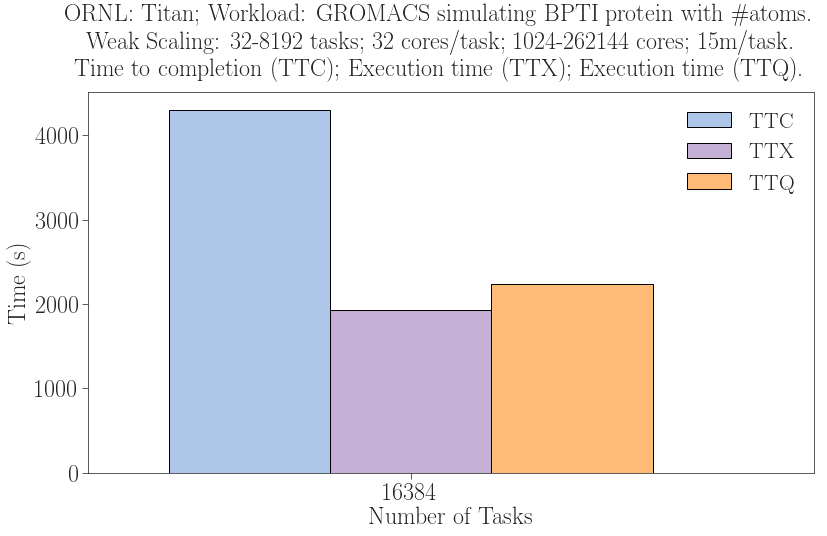

In [23]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111)  

title_head = 'ORNL: Titan; Workload: GROMACS simulating BPTI protein with \#atoms.'
title_work = 'Weak Scaling: 32-8192 tasks; 32 cores/task; 1024-262144 cores; 15m/task.' 
title_desc = 'Time to completion (TTC); Execution time (TTX); Execution time (TTQ).'
title = '%s\n%s\n%s' % (title_head, title_work, title_desc)
fig.suptitle(title, y=1.05)

# Plot means and std bars
gromacs_wscaling['TTC'].reset_index().plot(
    x='nunit', y='mean', yerr='std',
    position=1.5, width=0.25, color=tableau20[1], ax=ax, rot=0,
    label='TTC', kind='bar')

gromacs_wscaling['TTX'].reset_index().plot(
    x='nunit', y='mean', yerr='std', 
    position=0.5, width=0.25, color=tableau20[9], ax=ax, rot=0,
    label='TTX', kind='bar')

gromacs_wscaling['TTQ'].reset_index().plot(
    x='nunit', y='mean', yerr='std',
    position=-0.5, width=0.25, color=tableau20[3], ax=ax, rot=0,
    label='TTQ', kind='bar')

ax.set_xlabel('Number of Tasks')
ax.set_ylabel('Time (s)')
ax.set_xlim(-0.5)

#plt.savefig('figures/weak_scaling.pdf', dpi=600, bbox_inches='tight')